In [1]:
%load_ext autoreload
%autoreload 2
import emma_util
import nest_asyncio
nest_asyncio.apply()
import multiprocessing
multiprocessing.set_start_method("fork")
import pandas as pd
import stan
import numpy as np
from scipy.stats import pearsonr

from scipy.special import expit
import matplotlib.pyplot as plt
import arviz as az
import random


# Emma notes (8/22):

In general, let's build complexity iteratively. Start by getting reasonable results without worrying about ICAR prior/smoothing. Then use standard ICAR prior (with weight 0.5). Then use full CAR (maybe). Data generation code is reviewed + model without proper CAR prior is reviewed. Another thing it might be nice to implement at some point is using the information about where the annotated images are (i.e., what Census tracts). Could incorporate this as a multinomial (potentially?) 

Model with simple L2 smoothing (or no smoothing at all - stan_code_with_weighted_ICAR_prior):

1. Consistently recovers parameters for realistic parameter settings (with no smoothing)
2. Reviewed Stan code and looks good. 
3. ALso implemented L2 regularization for adjacent Census tracts. This isn't actually the "proper" way to do it, but might be useful on real data. Haven't tested how this performs. 

Model wih full CAR prior (stan_code_proper_car_prior):

1. Haven't reviewed this or verified it recovers correct params (recently; I think I did a while ago). When you do review, don't need to re-review all the Bayesian conditioning math; it should be pretty similar to the old code. 


empirical_p_y 0.04250206653079706
empirical_p_yhat 0.026274677176404266
p_y_hat_1_given_y_1 0.20576648191126207
p_y_hat_1_given_y_0 0.018130516327743693
p_y_1_given_y_hat_1 0.3328490258999005
p_y_1_given_y_hat_0 0.034667441665078305
dict_keys(['N', 'N_edges', 'node1', 'node2', 'n_images_by_area', 'n_classified_positive_by_area', 'n_classified_positive_annotated_positive_by_area', 'n_classified_positive_annotated_negative_by_area', 'n_classified_negative_annotated_positive_by_area', 'n_classified_negative_annotated_negative_by_area', 'n_non_annotated_by_area', 'n_non_annotated_by_area_classified_positive', 'use_ICAR_prior', 'ICAR_prior_weight'])
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   4% (401/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  35% (3500/10000)
Sampling:  59% (5900/10000)
Sampling:  75% (7500/10000)
Sampling:  99% (9900/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Mess

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.208  0.031   0.154    0.267      0.003    0.002   
p_y_hat_1_given_y_0  0.018  0.000   0.018    0.019      0.000    0.000   
phi_offset          -3.543  0.175  -3.890   -3.228      0.019    0.014   
p_y_1_given_y_hat_1  0.334  0.012   0.311    0.357      0.001    0.001   
p_y_1_given_y_hat_0  0.035  0.007   0.022    0.048      0.001    0.001   
...                    ...    ...     ...      ...        ...      ...   
p_y[995]             0.027  0.018   0.002    0.061      0.000    0.000   
p_y[996]             0.019  0.013   0.001    0.043      0.000    0.000   
p_y[997]             0.021  0.015   0.002    0.048      0.000    0.000   
p_y[998]             0.029  0.019   0.003    0.064      0.000    0.000   
p_y[999]             0.042  0.025   0.004    0.086      0.001    0.001   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      85.0     172.0   1.07  
p_y_hat_1_giv

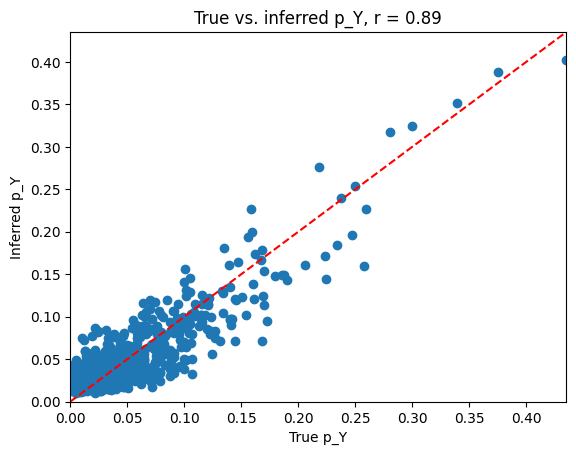

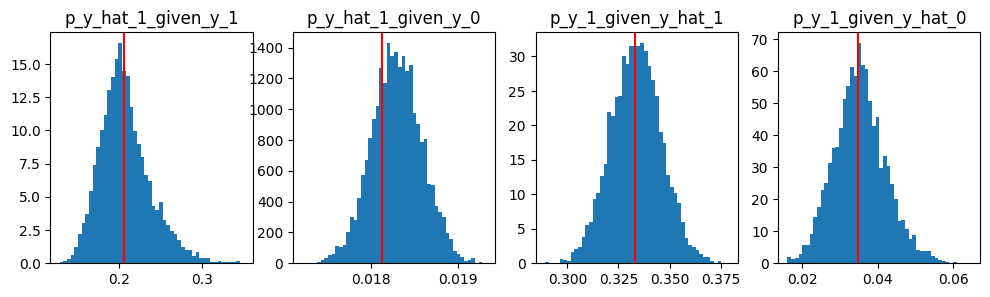

empirical_p_y 0.19155738793458954
empirical_p_yhat 0.1161727863755141
p_y_hat_1_given_y_1 0.5254804556810393
p_y_hat_1_given_y_0 0.019035161956446563
p_y_1_given_y_hat_1 0.8664650874049613
p_y_1_given_y_hat_0 0.10284558229531024
dict_keys(['N', 'N_edges', 'node1', 'node2', 'n_images_by_area', 'n_classified_positive_by_area', 'n_classified_positive_annotated_positive_by_area', 'n_classified_positive_annotated_negative_by_area', 'n_classified_negative_annotated_positive_by_area', 'n_classified_negative_annotated_negative_by_area', 'n_non_annotated_by_area', 'n_non_annotated_by_area_classified_positive', 'use_ICAR_prior', 'ICAR_prior_weight'])
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (203/10000)
Sampling:   3% (302/10000)
Sampling:   4% (401/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  20% (2000/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  24% (2400/10000)
Sampling:  25% (2500/10000)
Sampling:  26% (2600/10000)
Sampling:  28

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.562  0.024   0.519    0.610      0.005    0.004   
p_y_hat_1_given_y_0  0.020  0.001   0.018    0.022      0.000    0.000   
phi_offset          -1.817  0.070  -1.948   -1.689      0.014    0.010   
p_y_1_given_y_hat_1  0.860  0.008   0.844    0.875      0.001    0.000   
p_y_1_given_y_hat_0  0.089  0.009   0.072    0.105      0.002    0.001   
...                    ...    ...     ...      ...        ...      ...   
p_y[995]             0.158  0.019   0.122    0.193      0.001    0.001   
p_y[996]             0.159  0.019   0.124    0.195      0.001    0.001   
p_y[997]             0.439  0.032   0.378    0.499      0.005    0.003   
p_y[998]             0.218  0.022   0.177    0.260      0.002    0.001   
p_y[999]             0.717  0.042   0.642    0.798      0.007    0.005   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      22.0     136.0   1.18  
p_y_hat_1_giv

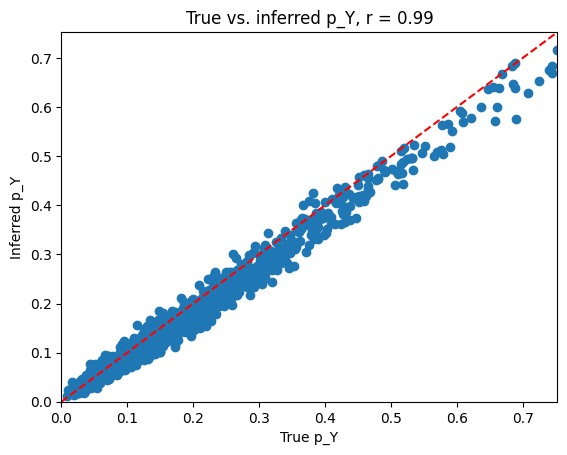

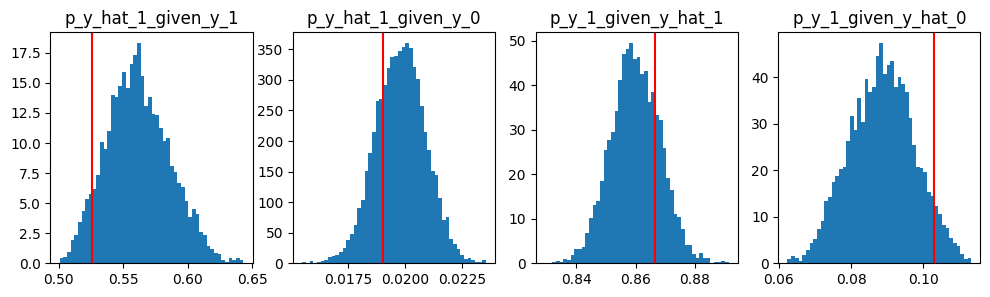

empirical_p_y 0.2786206192725494
empirical_p_yhat 0.07020469992385911
p_y_hat_1_given_y_1 0.22214167400640356
p_y_hat_1_given_y_0 0.010873516255794432
p_y_1_given_y_hat_1 0.8816112147054486
p_y_1_given_y_hat_0 0.23309148634855079
dict_keys(['N', 'N_edges', 'node1', 'node2', 'n_images_by_area', 'n_classified_positive_by_area', 'n_classified_positive_annotated_positive_by_area', 'n_classified_positive_annotated_negative_by_area', 'n_classified_negative_annotated_positive_by_area', 'n_classified_negative_annotated_negative_by_area', 'n_non_annotated_by_area', 'n_non_annotated_by_area_classified_positive', 'use_ICAR_prior', 'ICAR_prior_weight'])
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   4% (401/10000)
Sampling:   5% (501/10000)
Sampling:   6% (601/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  20% (2000/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  23% (2300/10000)
Sampling:  24% (2400/10000)
Sampling:  25% (2500/10000)
Sampling:  27

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.224  0.006   0.214    0.236      0.000    0.000   
p_y_hat_1_given_y_0  0.011  0.001   0.009    0.012      0.000    0.000   
phi_offset          -1.143  0.058  -1.253   -1.036      0.004    0.003   
p_y_1_given_y_hat_1  0.888  0.009   0.871    0.903      0.000    0.000   
p_y_1_given_y_hat_0  0.232  0.009   0.215    0.247      0.001    0.000   
...                    ...    ...     ...      ...        ...      ...   
p_y[995]             0.511  0.049   0.423    0.604      0.001    0.001   
p_y[996]             0.433  0.045   0.347    0.515      0.001    0.001   
p_y[997]             0.032  0.015   0.007    0.058      0.000    0.000   
p_y[998]             0.422  0.046   0.335    0.506      0.001    0.001   
p_y[999]             0.408  0.044   0.325    0.492      0.001    0.001   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1     204.0     363.0   1.01  
p_y_hat_1_giv

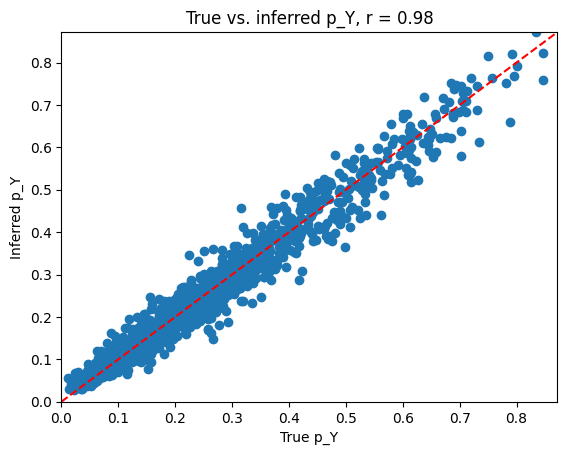

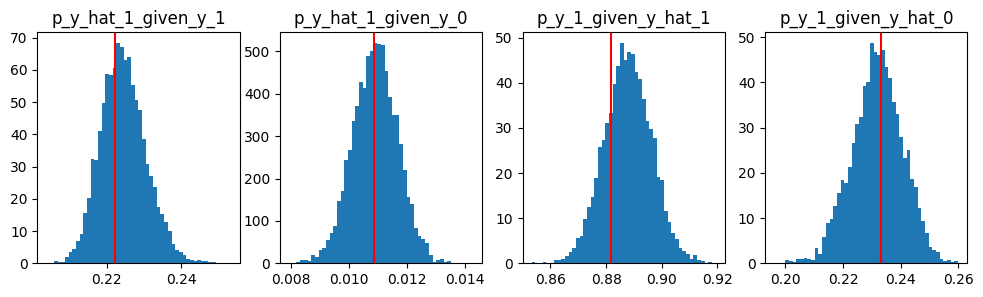

empirical_p_y 0.03465002633785825
empirical_p_yhat 0.02320430281640164
p_y_hat_1_given_y_1 0.25755958907932275
p_y_hat_1_given_y_0 0.014631919531712868
p_y_1_given_y_hat_1 0.38460308916751246
p_y_1_given_y_hat_0 0.026336704662875264
dict_keys(['N', 'N_edges', 'node1', 'node2', 'n_images_by_area', 'n_classified_positive_by_area', 'n_classified_positive_annotated_positive_by_area', 'n_classified_positive_annotated_negative_by_area', 'n_classified_negative_annotated_positive_by_area', 'n_classified_negative_annotated_negative_by_area', 'n_non_annotated_by_area', 'n_non_annotated_by_area_classified_positive', 'use_ICAR_prior', 'ICAR_prior_weight'])
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   4% (401/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  34% (3400/10000)
Sampling:  45% (4500/10000)
Sampling:  63% (6300/10000)
Sampling:  87% (8700/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation too

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.237  0.033   0.177    0.298      0.003    0.002   
p_y_hat_1_given_y_0  0.015  0.000   0.014    0.015      0.000    0.000   
phi_offset          -3.636  0.164  -3.953   -3.331      0.016    0.012   
p_y_1_given_y_hat_1  0.400  0.012   0.377    0.423      0.001    0.000   
p_y_1_given_y_hat_0  0.031  0.006   0.020    0.043      0.001    0.000   
...                    ...    ...     ...      ...        ...      ...   
p_y[995]             0.017  0.011   0.001    0.037      0.000    0.000   
p_y[996]             0.038  0.020   0.004    0.075      0.001    0.000   
p_y[997]             0.027  0.016   0.002    0.057      0.000    0.000   
p_y[998]             0.011  0.007   0.001    0.024      0.000    0.000   
p_y[999]             0.096  0.030   0.042    0.154      0.001    0.001   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      99.0     215.0   1.05  
p_y_hat_1_giv

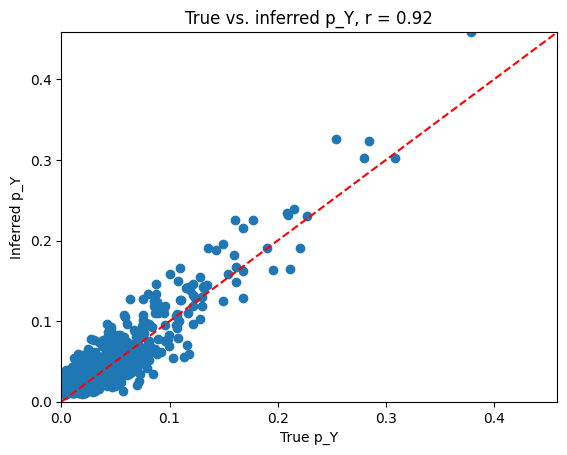

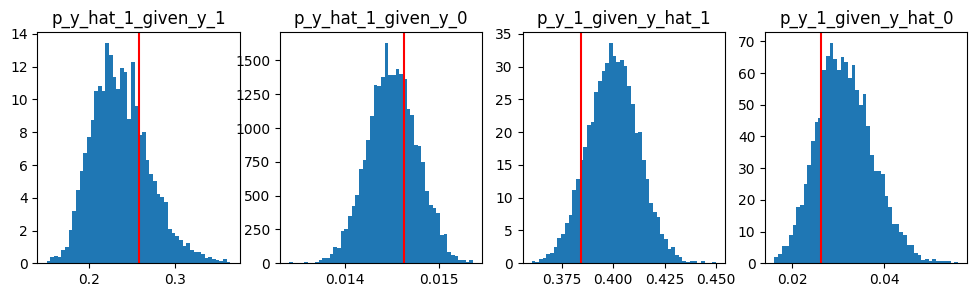

empirical_p_y 0.08279733680318367
empirical_p_yhat 0.05561328637967057
p_y_hat_1_given_y_1 0.4611974466585353
p_y_hat_1_given_y_0 0.019048085230915265
p_y_1_given_y_hat_1 0.6866330477767619
p_y_1_given_y_hat_0 0.047238504985324954
dict_keys(['N', 'N_edges', 'node1', 'node2', 'n_images_by_area', 'n_classified_positive_by_area', 'n_classified_positive_annotated_positive_by_area', 'n_classified_positive_annotated_negative_by_area', 'n_classified_negative_annotated_positive_by_area', 'n_classified_negative_annotated_negative_by_area', 'n_non_annotated_by_area', 'n_non_annotated_by_area_classified_positive', 'use_ICAR_prior', 'ICAR_prior_weight'])
Building...



Building: found in cache, done.Messages from stanc:
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   4% (400/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  20% (2000/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  23% (2300/10000)
Sampling:  24% (2400/10000)
Sampling:  25% (2500/10000)
Sampling:  26

                      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
p_y_hat_1_given_y_1  0.439  0.033   0.380    0.496      0.007    0.005   
p_y_hat_1_given_y_0  0.019  0.001   0.018    0.020      0.000    0.000   
phi_offset          -2.735  0.097  -2.912   -2.556      0.020    0.015   
p_y_1_given_y_hat_1  0.685  0.010   0.667    0.703      0.001    0.001   
p_y_1_given_y_hat_0  0.052  0.007   0.040    0.066      0.002    0.001   
...                    ...    ...     ...      ...        ...      ...   
p_y[995]             0.100  0.020   0.061    0.135      0.002    0.001   
p_y[996]             0.082  0.018   0.046    0.113      0.001    0.001   
p_y[997]             0.017  0.008   0.003    0.033      0.000    0.000   
p_y[998]             0.084  0.018   0.051    0.117      0.001    0.001   
p_y[999]             0.041  0.014   0.017    0.068      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
p_y_hat_1_given_y_1      22.0     118.0   1.15  
p_y_hat_1_giv

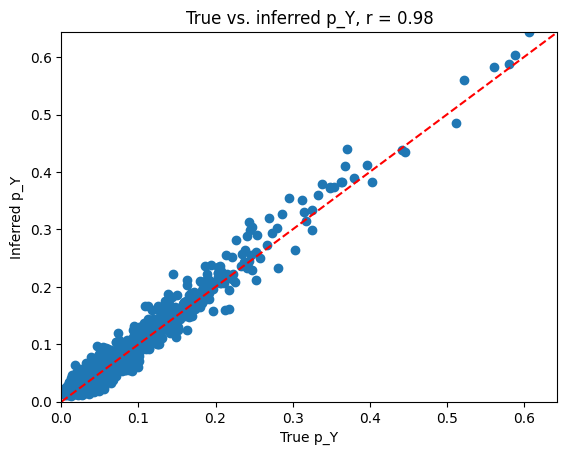

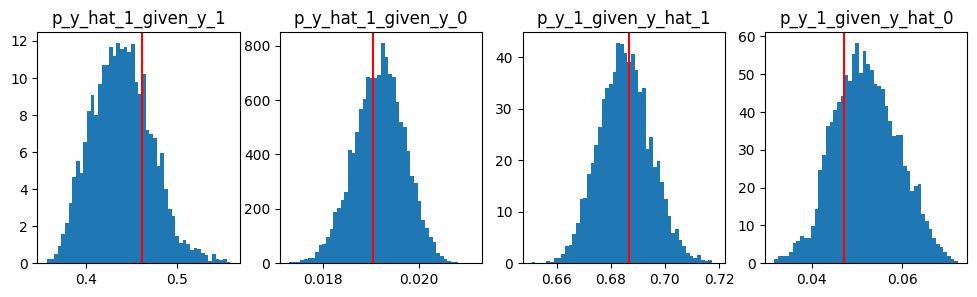

In [16]:
icar_prior_setting = 'none'
annotations_have_locations = True
use_simulated_data = True
assert icar_prior_setting in ['none', 'cheating', 'proper', 'just_model_p_y']
stan_code_with_weighted_ICAR_prior = open('stan_models/weighted_ICAR_prior.stan').read()
stan_code_proper_car_prior = open('stan_models/proper_car_prior.stan').read()
stan_model_uniform_p_y = open('stan_models/uniform_p_y_prior_just_for_debugging.stan').read()
stan_code_with_weighted_ICAR_prior_annotations_have_locations = open('stan_models/weighted_ICAR_prior_annotations_have_locations.stan').read()

for i in range(5):
    NUM_WARMUP = 1000#3000
    NUM_SAMPLES = 1500
    if use_simulated_data:
        N = 1000
        data_to_use = emma_util.generate_simulated_data(N=N, 
                                                images_per_location=1000, 
                                                total_annotated_classified_negative=500, 
                                                total_annotated_classified_positive=500, 
                                                icar_prior_setting=icar_prior_setting, 
                                                annotations_have_locations=annotations_have_locations)
    else:
        data_to_use = emma_util.read_real_data(single_compartment_for_debugging=False)
    if icar_prior_setting == 'proper':
        raise Exception("Haven't verified that this model actually works! Need to review it / check on simulated data. No need to review the parts which are identical to the other model.")
        W = np.zeros((N, N))
        
        for i in range(len(simulated_data['observed_data']['node1'])):
            W[simulated_data['observed_data']['node1'][i] - 1, 
                                simulated_data['observed_data']['node2'][i] - 1] = 1
            W[simulated_data['observed_data']['node2'][i] - 1, 
                                simulated_data['observed_data']['node1'][i] - 1] = 1
        del simulated_data['observed_data']['node1']
        del simulated_data['observed_data']['node2']
        simulated_data['observed_data']['W'] = W
        simulated_data['observed_data']['W_n'] = int(W.sum() / 2)
        model = stan.build(stan_code_proper_car_prior, data=simulated_data['observed_data'])
    elif icar_prior_setting == 'cheating':
        data_to_use['observed_data']['use_ICAR_prior'] = 1
        data_to_use['observed_data']['ICAR_prior_weight'] = 0.5
        if annotations_have_locations:
            model = stan.build(stan_code_with_weighted_ICAR_prior_annotations_have_locations, data=data_to_use['observed_data'])
        else:
            model = stan.build(stan_code_with_weighted_ICAR_prior, data=data_to_use['observed_data'])
    elif icar_prior_setting == 'none':
        data_to_use['observed_data']['use_ICAR_prior'] = 0
        data_to_use['observed_data']['ICAR_prior_weight'] = 0
        print(data_to_use['observed_data'].keys())
        if annotations_have_locations:
            model = stan.build(stan_code_with_weighted_ICAR_prior_annotations_have_locations, data=data_to_use['observed_data'])
        else:
            model = stan.build(stan_code_with_weighted_ICAR_prior, data=data_to_use['observed_data'])
    elif icar_prior_setting == 'just_model_p_y':
        del data_to_use['observed_data']['node1']
        del data_to_use['observed_data']['node2']
        del data_to_use['observed_data']['N_edges']
        model = stan.build(stan_model_uniform_p_y, data=data_to_use['observed_data'])
    else:
        raise ValueError("Invalid icar_prior_options", icar_prior_setting)
    fit = model.sample(num_chains=4, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
    df = fit.to_frame()
    if icar_prior_setting == 'just_model_p_y':
        print(az.summary(fit, var_names=['p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                        'p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
                                        'empirical_p_yhat', 'p_y']))
    else:
        print(az.summary(fit, var_names=['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 'phi_offset', 
                                    'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
                                    'empirical_p_yhat', 'p_y']))
        
    if use_simulated_data:
        inferred_p_y = [df[f'p_y.{i}'].mean() for i in range(1, N + 1)]
        plt.scatter(data_to_use['parameters']['p_Y'], inferred_p_y)
        plt.title("True vs. inferred p_Y, r = %.2f" %
                pearsonr(data_to_use['parameters']['p_Y'], inferred_p_y)[0])
        max_val = max(max(data_to_use['parameters']['p_Y']), max(inferred_p_y))
        plt.xlabel("True p_Y")
        plt.ylabel("Inferred p_Y")
        plt.plot([0, max_val], [0, max_val], 'r--')
        plt.xlim([0, max_val])
        plt.ylim([0, max_val])
        plt.figure(figsize=[12, 3])


        if icar_prior_setting == 'proper':
            param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset', 'alpha', 'tau']
        elif icar_prior_setting == 'just_model_p_y':
            param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0', 
            'phi_offset']
        else:
            param_names = ['p_y_hat_1_given_y_1', 'p_y_hat_1_given_y_0', 
            'p_y_1_given_y_hat_1', 'p_y_1_given_y_hat_0']
        for k in param_names:
            plt.subplot(1, len(param_names), param_names.index(k) + 1)
            # histogram of posterior samples
            plt.hist(df[k], bins=50, density=True)
            plt.title(k)
            plt.axvline(data_to_use['parameters'][k], color='red')
        plt.show()
    else:
        empirical_p_yhat = data_to_use['observed_data']['n_classified_positive_by_area'] / data_to_use['observed_data']['n_images_by_area']
        print("Warning: %i of %i empirical p_yhat values are 0; these are being ignored" % (sum(np.isnan(empirical_p_yhat)), len(empirical_p_yhat)))
        inferred_p_y = np.array([df[f'p_y.{i}'].mean() for i in range(1, len(empirical_p_yhat) + 1)])
        inferred_p_y_CIs = [df[f'p_y.{i}'].quantile([0.025, 0.975]) for i in range(1, len(empirical_p_yhat) + 1)]
        n_images_by_area = data_to_use['observed_data']['n_images_by_area']
        # make errorbar plot
        image_cutoff = 100

        plt.errorbar(empirical_p_yhat[n_images_by_area >= image_cutoff], inferred_p_y[n_images_by_area >= image_cutoff], 
                    yerr=np.array(inferred_p_y_CIs)[n_images_by_area >= image_cutoff].T, fmt='o', 
                    color='blue', 
                    ecolor='lightgray', elinewidth=1, capsize=3, alpha=0.5, 
                    label="n_images_by_area >= %i" % image_cutoff)

        plt.errorbar(empirical_p_yhat[n_images_by_area < image_cutoff], inferred_p_y[n_images_by_area < image_cutoff], 
                    yerr=np.array(inferred_p_y_CIs)[n_images_by_area < image_cutoff].T, fmt='o', 
                    color='red', 
                    ecolor='lightgray', elinewidth=1, capsize=3, alpha=0.5, 
                    label="n_images_by_area < %i" % image_cutoff)
        plt.legend()

        # plot prior on p_y as vertical line. 
        phi_offset = df['phi_offset'].mean()
        plt.axhline(expit(phi_offset), color='black', linestyle='--')
        is_nan = np.isnan(empirical_p_yhat)
        plt.title("Correlation between empirical $p(\\hat y = 1)$ and inferred $p(y = 1)$, r = %.2f" % pearsonr(empirical_p_yhat[~is_nan], inferred_p_y[~is_nan])[0])
        plt.xlabel("empirical $p(\\hat y = 1)$")
        plt.ylabel("inferred $p(y = 1)$")
        # logarithmic axes
        plt.xscale('log')
        plt.yscale('log')




In [15]:
np.random.choice([], 5)

ValueError: 'a' cannot be empty unless no samples are taken